# <font color='red'>Clustering Assignment</font>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<br>

In [2]:
!pip install networkx==2.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.6 MB/s 
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556008 sha256=accf297d66a1b01f08feccfd7fc36fbc6c4fa24b0b2bce2cbfd70539781e5bd3
  Stored in directory: /root/.cache/pip/wheels/44/e6/b8/4efaab31158e9e9ca9ed80b11f6b11130bac9a9672b3cbbeaf
Successfully built networkx
  Attempting uninstall: networkx
    Found existing installation: networkx 2.6.3
    Uninstalling networkx-2.6.3:
      Successfully uninstalled networkx-2.6.3


In [3]:
!pip install stellargraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 435 kB 5.1 MB/s 


In [4]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# you need to have tensorflow 
from stellargraph.data import UniformRandomMetaPathWalk
from stellargraph import StellarGraph

In [5]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assignment files/movie_actor_network.csv', index_col=False, names=['movie','actor'])

In [6]:
edges = [tuple(x) for x in data.values.tolist()]

In [7]:
B = nx.Graph()
B.add_nodes_from(data['movie'].unique(), bipartite=0, label='movie')
B.add_nodes_from(data['actor'].unique(), bipartite=1, label='actor')
B.add_edges_from(edges, label='acted')

In [8]:
A = list(nx.connected_component_subgraphs(B))[0]

In [9]:
print("number of nodes", A.number_of_nodes())
print("number of edges", A.number_of_edges())

number of nodes 4703
number of edges 9650


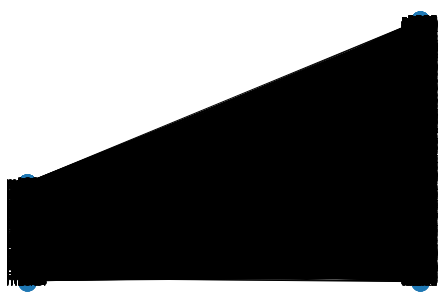

In [10]:
l, r = nx.bipartite.sets(A)
pos = {}

pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
  
nx.draw(A, pos=pos, with_labels=True)
plt.show()

In [11]:
movies = []
actors = []
for i in A.nodes():
    if 'm' in i:
        movies.append(i)
    if 'a' in i:
        actors.append(i)
print('number of movies ', len(movies))
print('number of actors ', len(actors))

number of movies  1292
number of actors  3411


In [12]:
# Create the random walker
rw = UniformRandomMetaPathWalk(StellarGraph(A))

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["movie", "actor", "movie"],
    ["actor", "movie", "actor"]
]

walks = rw.run(nodes=list(A.nodes()), # root nodes
               length=100,  # maximum length of a random walk
               n=1,        # number of random walks per root node 
               metapaths=metapaths
              )

print("Number of random walks: {}".format(len(walks)))

Number of random walks: 4703


In [13]:
from gensim.models import Word2Vec
model = Word2Vec(walks, size=128, window=5)

In [14]:
model.wv.vectors.shape  # 128-dimensional vector for each node in the graph

(4703, 128)

In [15]:
# Retrieve node embeddings and corresponding subjects
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = model.wv.vectors  # numpy.ndarray of size number of nodes times embeddings dimensionality
node_targets = [ A.node[node_id]['label'] for node_id in node_ids]

In [16]:
print(node_ids[:15],end ="")

['a973', 'a967', 'a964', 'a1731', 'a970', 'a969', 'a1057', 'a1028', 'a965', 'a1003', 'm1094', 'm1111', 'a966', 'm67', 'a959']

In [17]:
print(node_targets[:15], end ='')

['actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'actor', 'movie', 'movie', 'actor', 'movie', 'actor']

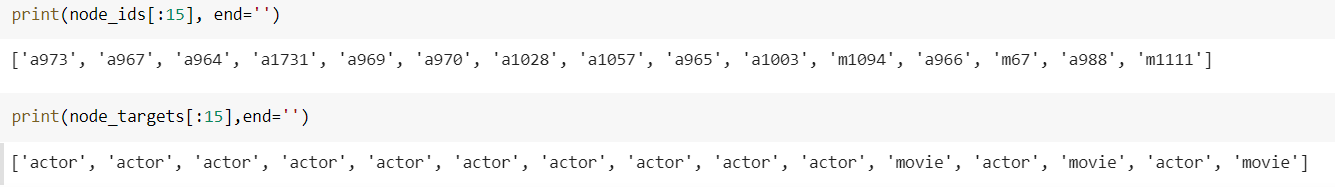

In [18]:
def data_split(node_ids,node_targets,node_embeddings):
    '''In this function, we will split the node embeddings into actor_embeddings , movie_embeddings '''
    actor_nodes,movie_nodes=[],[]
    actor_embeddings,movie_embeddings=[],[]
    # split the node_embeddings into actor_embeddings,movie_embeddings based on node_ids
    # By using node_embedding and node_targets, we can extract actor_embedding and movie embedding
    # By using node_ids and node_targets, we can extract actor_nodes and movie nodes
    for node,target, emb in zip(node_ids,node_targets,node_embeddings):
        if target == "actor":
            actor_nodes.append(node)
            actor_embeddings.append(emb)
        if target == "movie":
            movie_nodes.append(node)
            movie_embeddings.append(emb)
            
    return actor_nodes,movie_nodes,actor_embeddings,movie_embeddings


In [19]:
actor_nodes,movie_nodes,actor_embeddings,movie_embeddings= data_split(node_ids,node_targets,node_embeddings)

<font color='cyan'>Grader function - 1</font>

In [20]:
def grader_actors(data):
    assert(len(data)==3411)
    return True
grader_actors(actor_nodes)

True

<font color='cyan'>Grader function - 2</font>

In [21]:
def grader_movies(data):
    assert(len(data)==1292)
    return True
grader_movies(movie_nodes)

True

<font color='blue'>Calculating cost1</font>

Cost1 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(number of nodes in the largest connected component in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(total number of nodes in that cluster i)}}$ where N= number of clusters <br><br>
<br>

In [22]:
def cost1(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    largest_cc = max(nx.connected_components(graph), key=len) #https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html#connected-components
    cost1=  len(largest_cc)/graph.number_of_nodes()/number_of_clusters
    
    
    return cost1

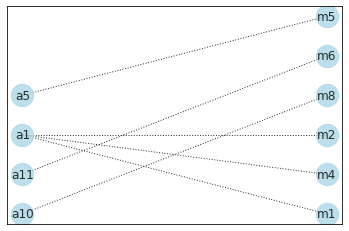

In [23]:
import networkx as nx
from networkx.algorithms import bipartite
graded_graph= nx.Graph()
graded_graph.add_nodes_from(['a1','a5','a10','a11'], bipartite=0) # Add the node attribute "bipartite"
graded_graph.add_nodes_from(['m1','m2','m4','m6','m5','m8'], bipartite=1)
graded_graph.add_edges_from([('a1','m1'),('a1','m2'),('a1','m4'),('a11','m6'),('a5','m5'),('a10','m8')])
l={'a1','a5','a10','a11'};r={'m1','m2','m4','m6','m5','m8'}
pos = {}
pos.update((node, (1, index)) for index, node in enumerate(l))
pos.update((node, (2, index)) for index, node in enumerate(r))
nx.draw_networkx(graded_graph, pos=pos, with_labels=True,node_color='lightblue',alpha=0.8,style='dotted',node_size=500)

<font color='cyan'>Grader function - 3</font>

In [24]:
graded_cost1=cost1(graded_graph,3)
def grader_cost1(data):
    assert(data==((1/3)*(4/10))) # 1/3 is number of clusters
    return True
grader_cost1(graded_cost1)

True

<font color='blue'>Calculating cost2</font>

Cost2 = $\frac{1}{N}\sum_{\text{each cluster i}}  \frac{\text{(sum of degress of actor nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}{\text{(number of unique movie nodes in the graph with the actor nodes and its movie neighbours in cluster i)}}$ where N= number of clusters 

In [25]:
def cost2(graph,number_of_clusters):
    '''In this function, we will calculate cost1'''
    degree_sum = 0
    unq_movies = 0
    degrees = graph.degree()
    for node in degrees:
        if 'a' in node[0]:
            degree_sum += node[1]
        if 'm' in node[0]:
            unq_movies+= 1
    cost2= (1/number_of_clusters) * (degree_sum/unq_movies)
    
    return cost2

<font color='cyan'>Grader function - 4</font>

In [26]:
graded_cost2=cost2(graded_graph,3)
def grader_cost2(data):
    assert(data==((1/3)*(6/6))) # 1/3 is number of clusters
    return True
grader_cost2(graded_cost2)

True

# <font color='red'>Task 1 : Apply clustering algorithm to group similar actors</font>

<font color='blue'>Grouping similar actors</font>

In [34]:
def grid_search_kmeans(actor_embeddings,actor_nodes):
    cost_dict = {}
    for number_of_clusters in [3, 5, 10, 30, 50, 100, 200, 500]:
        algo = KMeans(n_clusters=number_of_clusters)
        algo.fit(actor_embeddings)
        clusters = algo.labels_ #cluster labels [0,1,...]
        cst1 = 0 #intialize cost values
        cst2 = 0
        for i in range(number_of_clusters):# for each cluster
            g1 = nx.Graph() #intialize empty graph
            # get indexes of cluster labels
            cluster_index = [index for index,value in enumerate(clusters) if value ==i]
            # getting actor labels based on cluster indexes
            labels = [actor_nodes[idx] for idx in cluster_index]

            for node in labels: # for each actor node
                sub_graph1 = nx.ego_graph(B,node) #subgraph with node 
                g1.add_nodes_from(sub_graph1.nodes()) # adding nodes to g1
                g1.add_edges_from(sub_graph1.edges()) # adding edges to g1
            # summing up cost1
            cst1 += cost1(g1, number_of_clusters) 
            #summming up cost2
            cst2 += cost2(g1, number_of_clusters) 
        #total cost for each cluster
        tot_cost = cst1*cst2
        #adding cost values to dictionary
        cost_dict[number_of_clusters]= tot_cost

        #getting max cost value 
        best_no_cluster = max(zip(cost_dict.values(),cost_dict.keys()))[1] #https://www.geeksforgeeks.org/python-get-key-with-maximum-value-in-dictionary/
        print("best n number of cluster =",best_no_cluster)
        print("cost value = ",cost_dict[best_no_cluster])

        return best_no_cluster

In [35]:
best_no_cluster = grid_search_kmeans(actor_embeddings,actor_nodes)

best n number of cluster = 3
cost value =  3.8372311707137476


In [36]:
algo = KMeans(n_clusters = best_no_cluster)
algo.fit(actor_embeddings)
clusters = algo.labels_

<font color='blue'>Displaying similar actor clusters</font>

In [30]:
from sklearn.manifold import TSNE

In [38]:
transform = TSNE #PCA
trans = transform(n_components=2)
actor_embeddings_2d = trans.fit_transform(actor_embeddings)

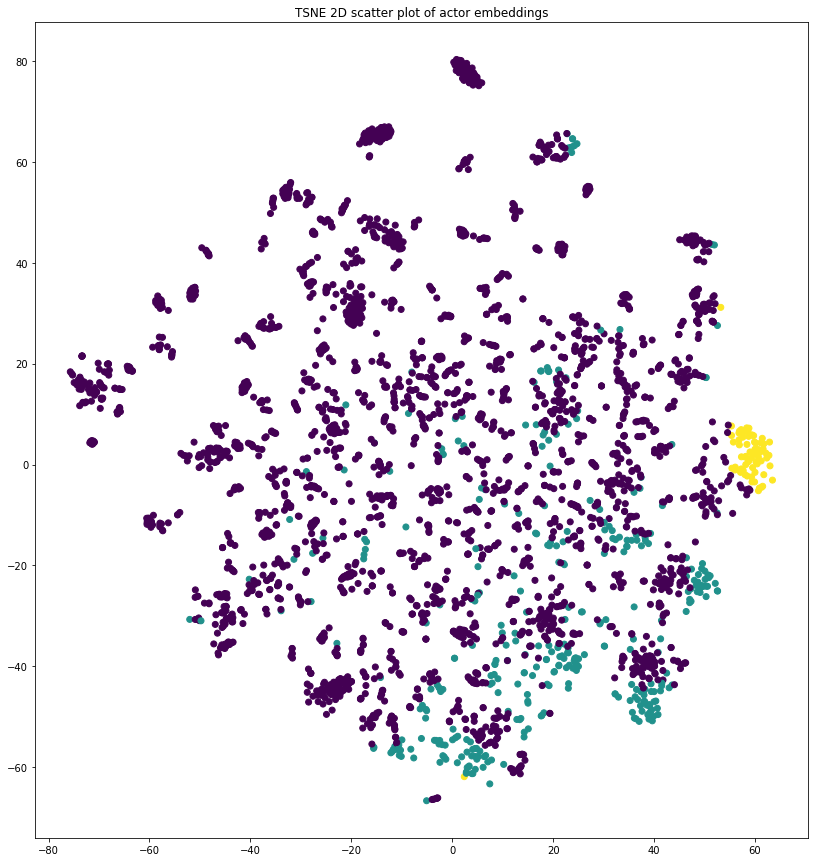

In [39]:
plt.figure(figsize=(20,15))
plt.axes().set(aspect = 'equal')
plt.scatter(actor_embeddings_2d[:,0],actor_embeddings_2d[:,1],c= clusters)
plt.title("TSNE 2D scatter plot of actor embeddings")
plt.show()

# <font color='red'>Task 2 : Apply clustering algorithm to group similar movies</font>

<font color='blue'>Grouping similar movies</font>

In [40]:
best_no_cluster = grid_search_kmeans(movie_embeddings,movie_nodes)

best n number of cluster = 3
cost value =  8.409927801186095


<font color='blue'>Displaying similar movie clusters</font>

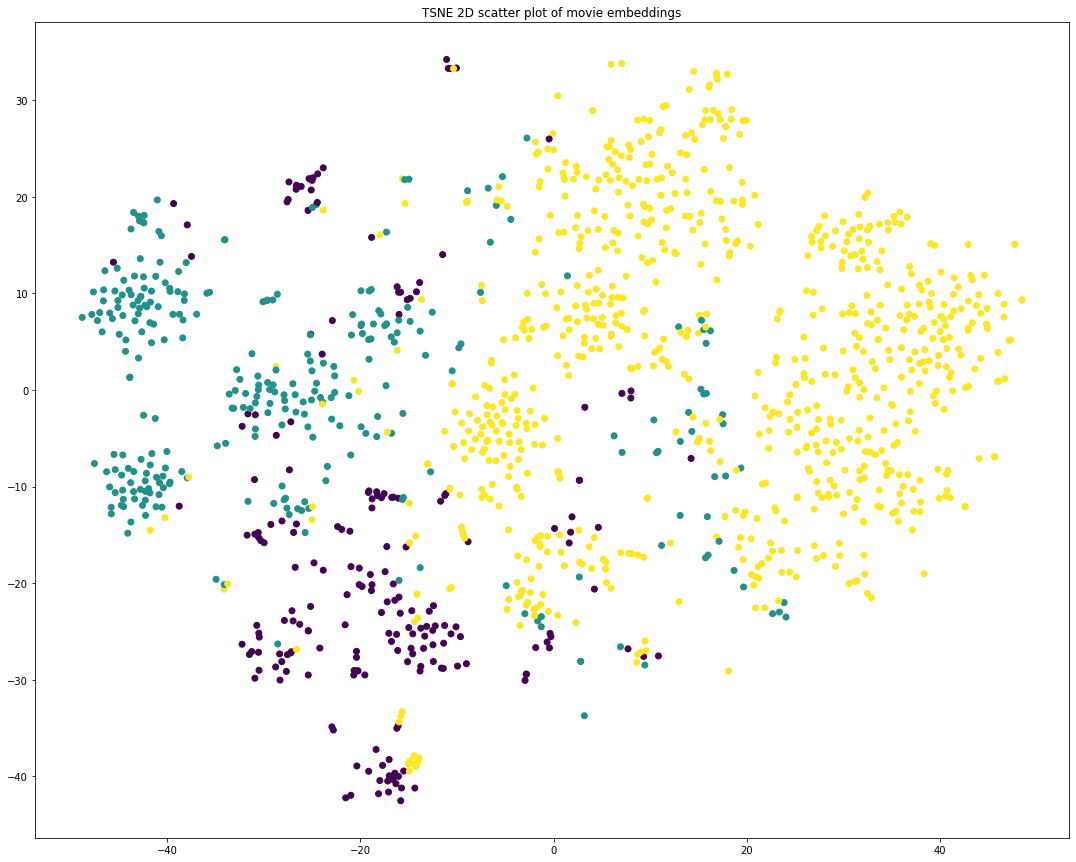

In [43]:
algo = KMeans(n_clusters = best_no_cluster)
algo.fit(movie_embeddings)
clusters = algo.labels_

movie_embeddings_2d = trans.fit_transform(movie_embeddings)

plt.figure(figsize=(20,15))
plt.axes().set(aspect = 'equal')
plt.scatter(movie_embeddings_2d[:,0],movie_embeddings_2d[:,1],c= clusters)
plt.title("TSNE 2D scatter plot of movie embeddings")
plt.show()